In [1]:
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal
from scipy.stats import zscore
import pandas as pd
import numpy as np
import math
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
import seaborn as sns
import timeit
%matplotlib inline

In [2]:
def is_similar(X, Y):
    if isinstance(X, list) and isinstance(Y, list):
        if len(X) == len(Y):
            return all([is_similar(x, Y[i]) for i, x in enumerate(X)])
        else:
            return False
    return abs(X-Y) <= 1e-7

In [3]:
df_input = pd.read_csv('../Mall_Customers.csv')
df = df_input.copy()
print(df.shape[0])

200


In [4]:
df["Gender"] = df["Gender"].astype("category").cat.codes

df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,19,15,39
1,2,1,21,15,81
2,3,0,20,16,6
3,4,0,23,16,77
4,5,0,31,17,40


## Normalize the dataset.

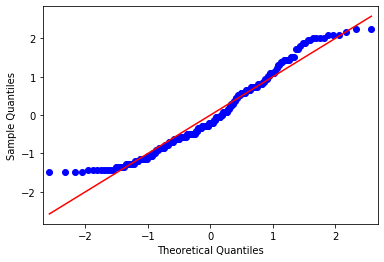

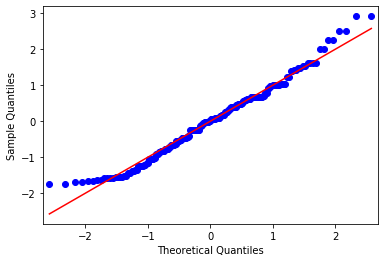

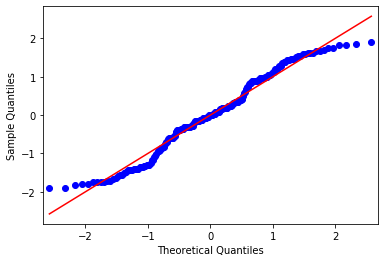

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,1,-1.424569,-1.738999,-0.434801
1,2,1,-1.281035,-1.738999,1.195704
2,3,0,-1.352802,-1.700830,-1.715913
3,4,0,-1.137502,-1.700830,1.040418
4,5,0,-0.563369,-1.662660,-0.395980


In [5]:
import statsmodels.api as sm 
import pylab as py


def normalize_data(x):
    for column in df.columns[2:]:
      df[column] = (df[column] - df[column].mean())/df[column].std(ddof=0)
    
    for column in df.columns[2:]:
      col_in_numpy = df[column].to_numpy()
      sm.qqplot(col_in_numpy, line ='s') 

normalize_data(df)
        
py.show()

df.head()

## Data visualization

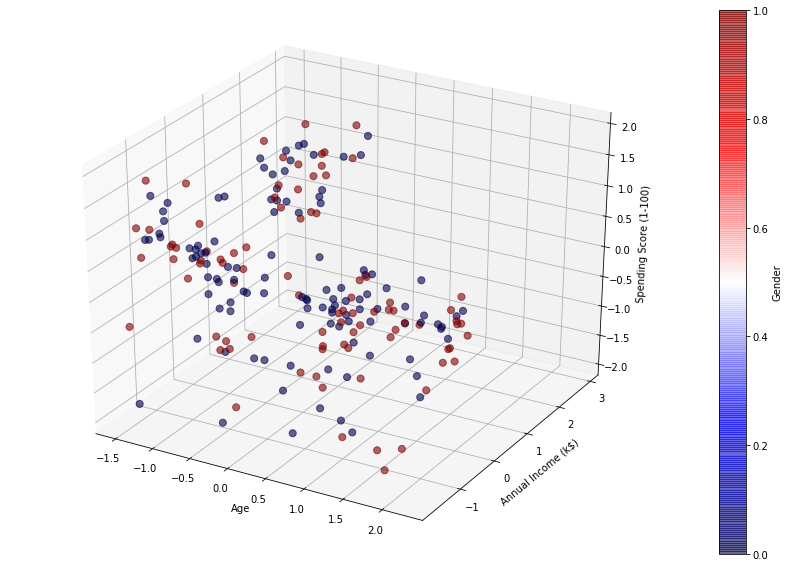

In [6]:
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection='3d')

xs = df['Age']
ys = df['Annual Income (k$)']
zs = df['Spending Score (1-100)']
c = df['Gender']

img = ax.scatter(xs, ys, zs, c=c, s=50, alpha=0.6, cmap='seismic')

ax.set_xlabel('Age')
ax.set_ylabel('Annual Income (k$)')
ax.set_zlabel('Spending Score (1-100)')
fig.colorbar(img, label='Gender')
plt.show()

In [7]:
points = df[list(set(df.columns)-set(['CustomerID']))].values

In [8]:
def initialize_rep(X, k, seed=None):
    if(seed):
        np.random.seed(seed)

    random_idx = np.random.choice(X.shape[0], size=k, replace=False)
    rep = X[random_idx, :]
    return rep

In [9]:
from KMeans import Kmeans

In [10]:
kmeans = Kmeans(3, 200)
kmeans.fit(points)

X_test = np.array([[-1.4, -1.7, -0.4, 1.1]])
y_pred = kmeans.predict(X_test)

print("y_pred = ", y_pred)

[[3.04530081 2.59334552 4.03864012]]
y_pred =  [1]


## Compare it with sklearn's result

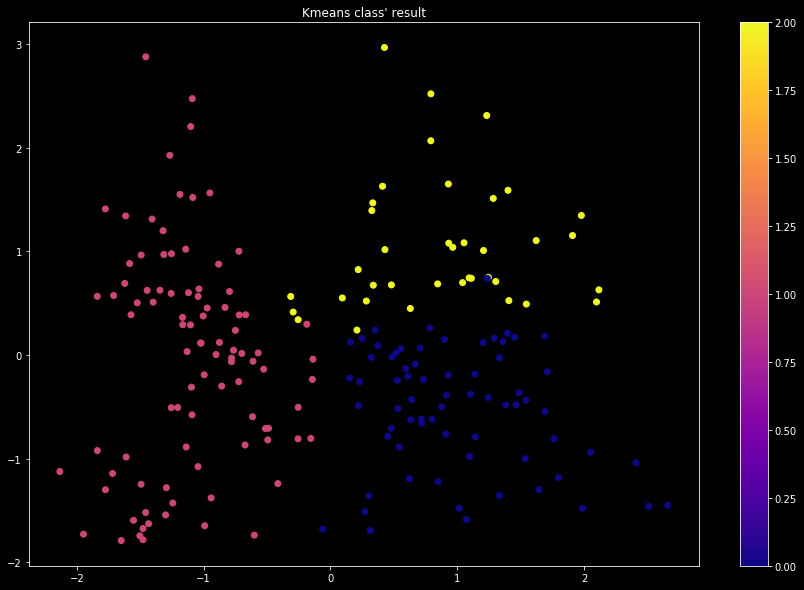

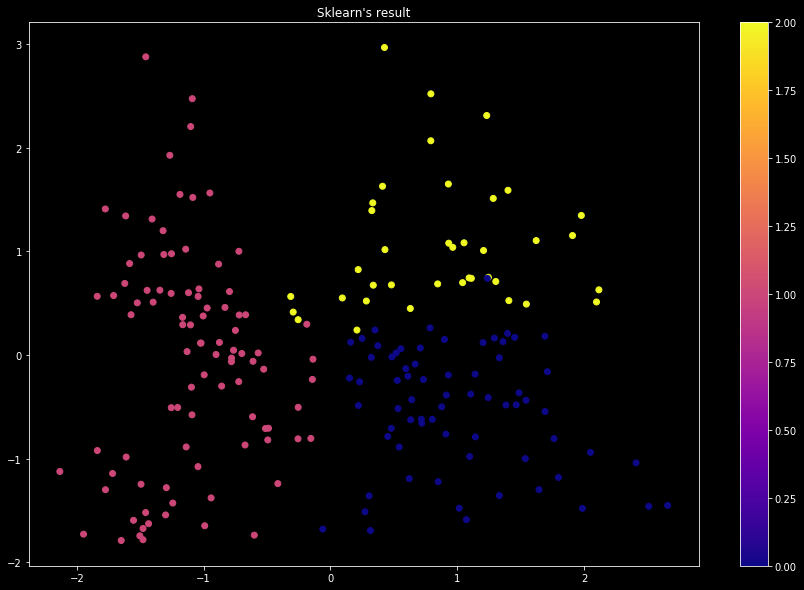

In [11]:
from sklearn.cluster import KMeans


def plot_2d(X, title, labels):
    plt.style.use('dark_background')
    pca_2d = PCA(n_components=2).fit(X).transform(X)
    plt.figure(figsize=(15, 10))
    plt.title(title)
    img = plt.scatter(pca_2d[:, 0], pca_2d[:, 1], c=labels, cmap='plasma')
    plt.colorbar(img)
    plt.show()


# Kmeans class
# kmeans.labels: store the data labels after running the Kmeans algorithm.
plot_2d(points, "Kmeans class' result", kmeans.labels)

# KMeans sklearn
kmeans_comparison = KMeans(n_clusters=3,
                           init=kmeans.initial_centroids,  # storing initial centroid of Kmeans.
                           n_init=1,
                           max_iter=1000000000)
kmeans_comparison.fit(points)
plot_2d(points, "Sklearn's result", kmeans_comparison.labels_)

Number of customers in each cluster:
Cluster
0    69
1    93
2    38
Name: CustomerID, dtype: int64

Gender distribution in each cluster:


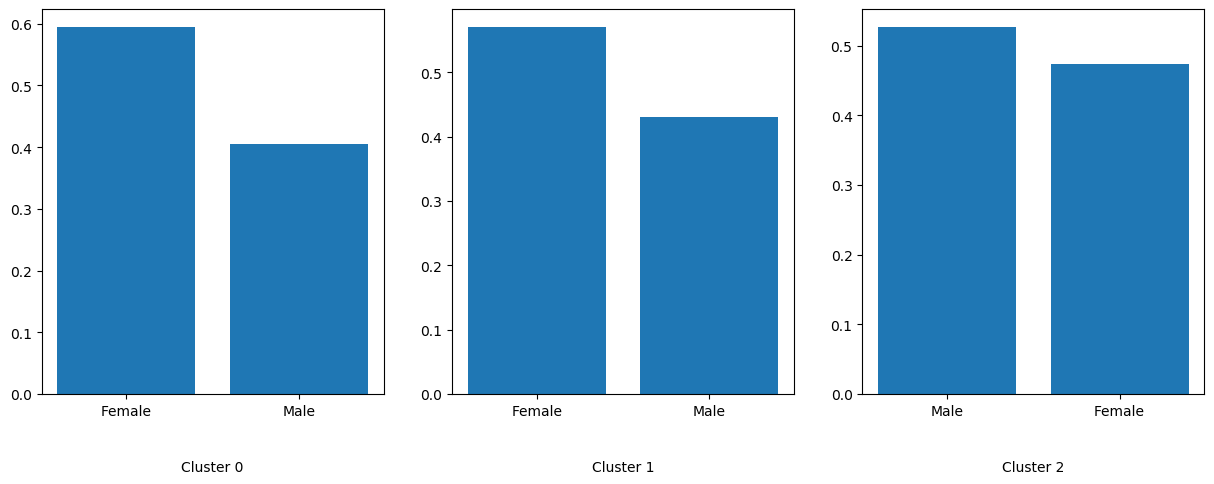


Annual Income (k$) distribution in each cluster:


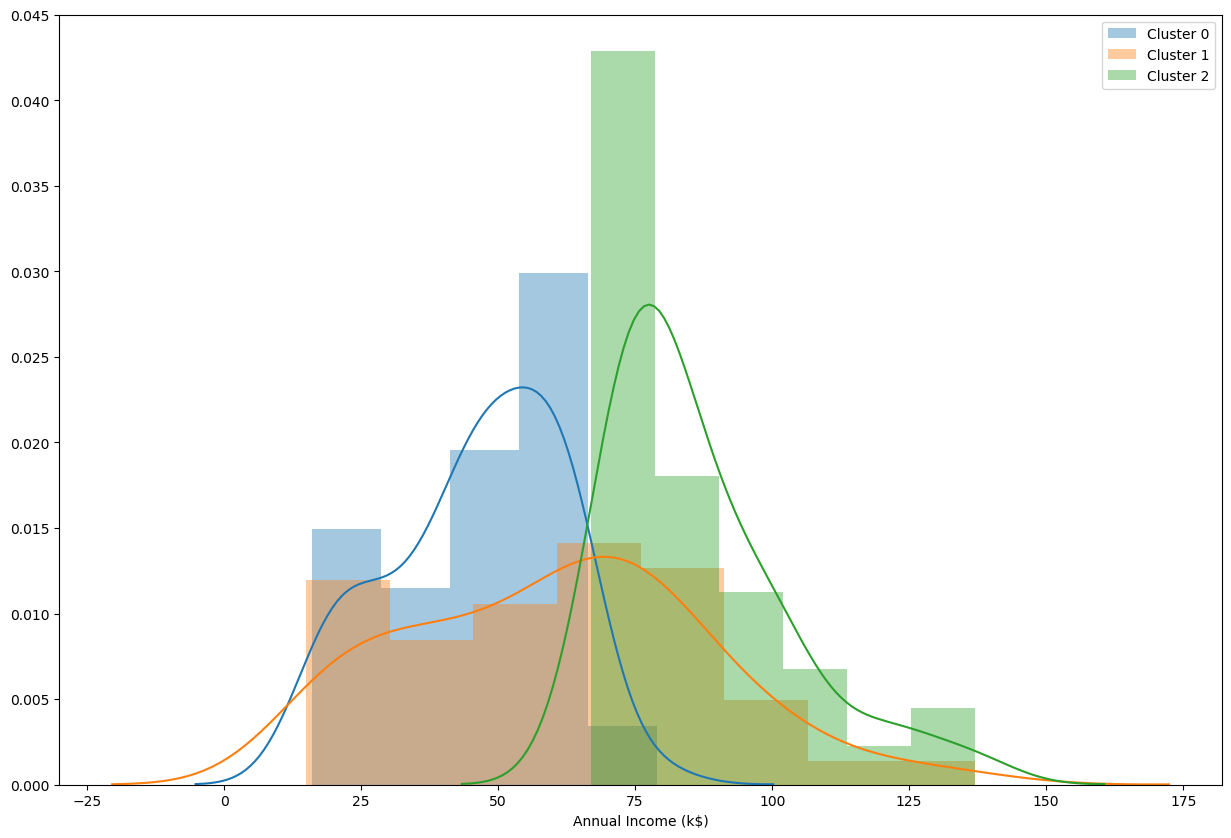

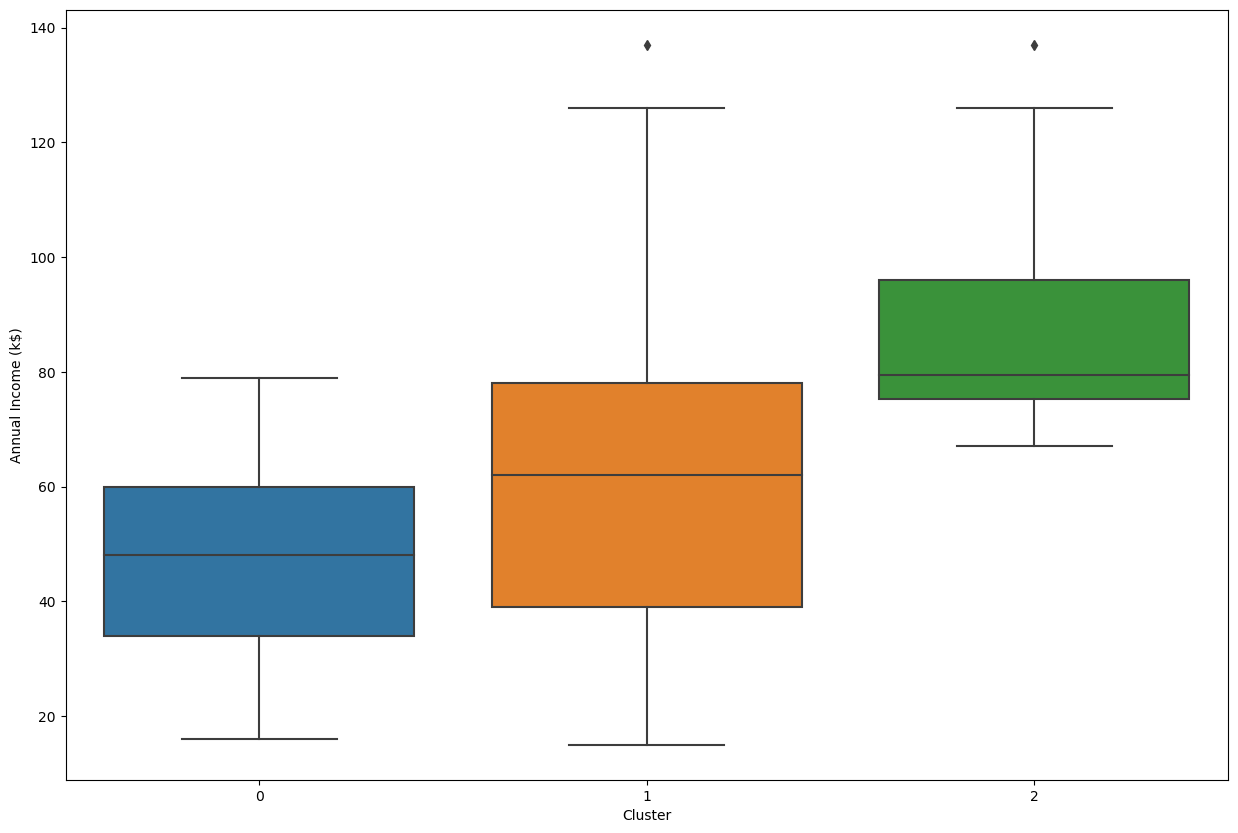


Age distribution in each cluster:


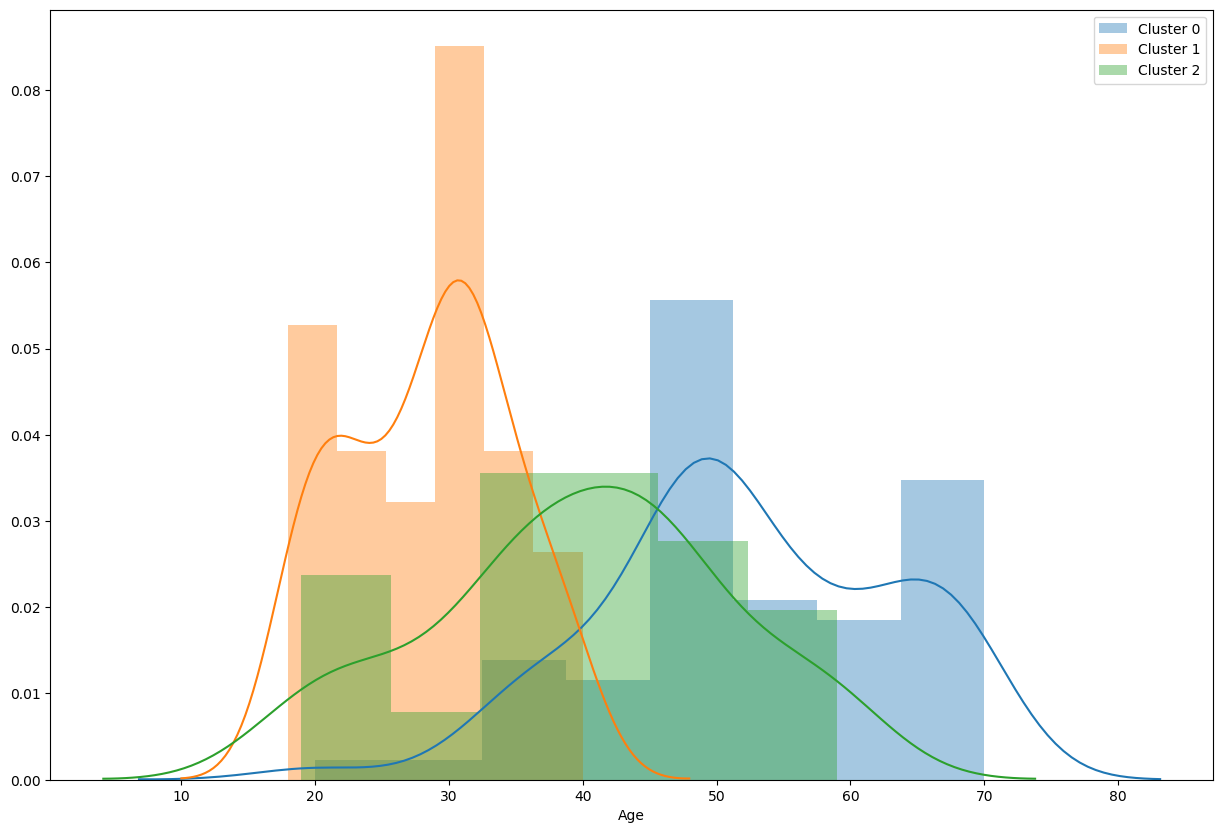

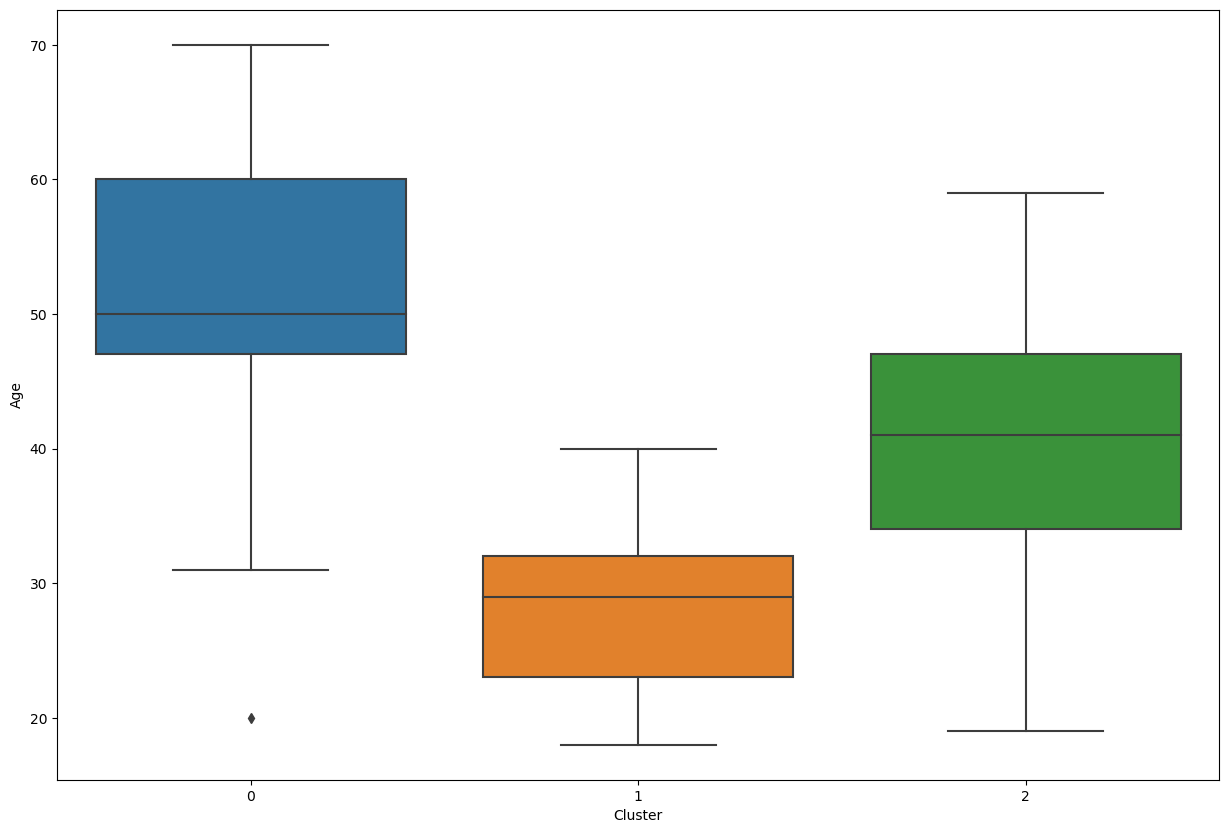


Spending Score (1-100) distribution in each cluster:


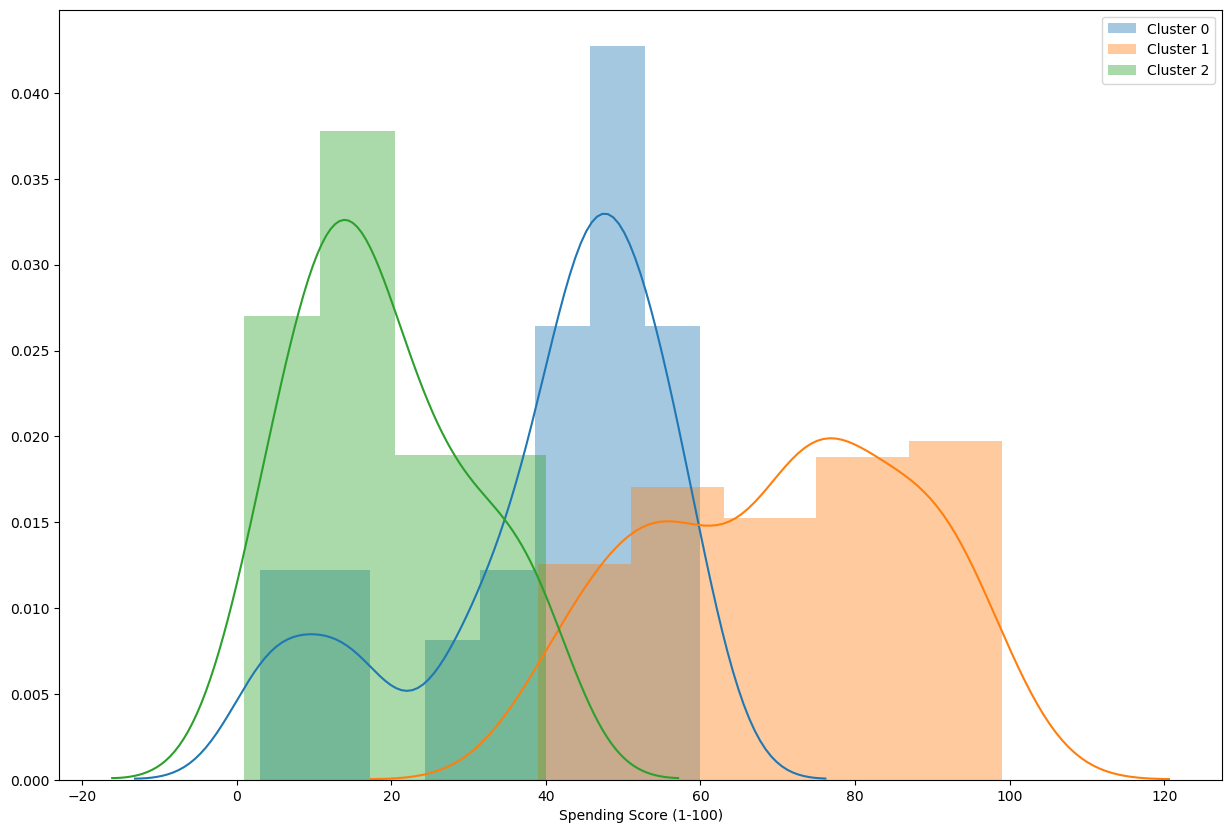

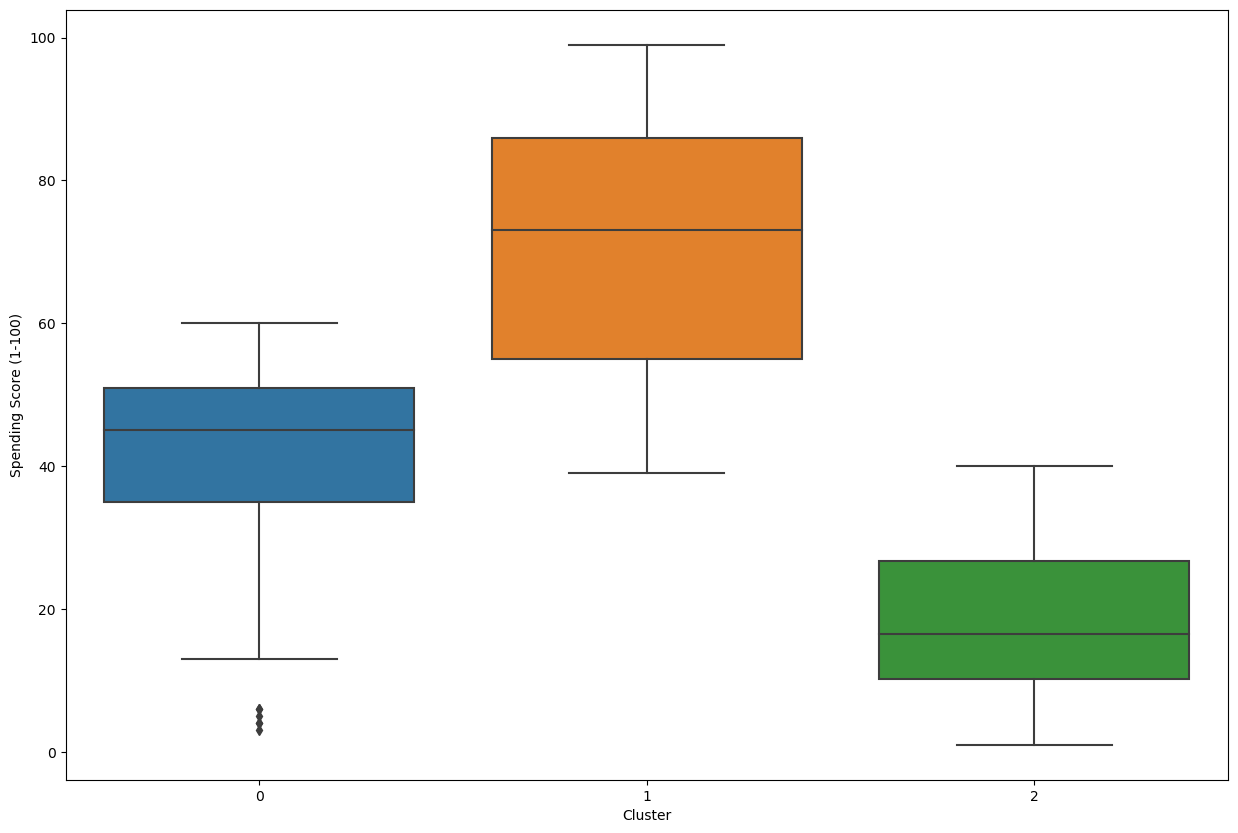

In [12]:
df_copy_kmeans = df_input.copy()
df_copy_kmeans['Cluster'] = kmeans.labels


def visualize_cat(data, column_name):
    plt.style.use('default')
    fig, axes = plt.subplots(figsize=(15, 5), nrows=1, ncols=3)
    for c in set(kmeans.labels):
        df_cluster = data[data['Cluster'] == c]
        count = df_cluster[column_name].value_counts(normalize=True)
        axes[c].bar(count.index, count.values)
        axes[c].text(0.5, -0.2, 'Cluster ' + str((c)),
                     horizontalalignment='center', transform=axes[c].transAxes)
    plt.show()


def visualize_num(data, column_name):
    plt.style.use('default')
    # histogram
    plt.figure(figsize=(15, 10))
    for c in set(kmeans.labels):
        df_cluster = data[data['Cluster'] == c]
        sns.distplot(df_cluster[column_name],
                     norm_hist=True, label='Cluster ' + str(c))
        plt.legend()
    plt.show()

    # boxplot
    plt.figure(figsize=(15, 10))
    sns.boxplot(x='Cluster', y=column_name, data=data)
    plt.show()


# exploratory data analysis
print('Number of customers in each cluster:')
print(df_copy_kmeans.groupby('Cluster')['CustomerID'].nunique())
print('='*90 + '\n')

print('Gender distribution in each cluster:')
visualize_cat(df_copy_kmeans, 'Gender')
print('='*90 + '\n')

for c in set(df_copy_kmeans.columns) - set(['CustomerID', 'Gender', 'Cluster']):
    print('{} distribution in each cluster:'.format(c))
    visualize_num(df_copy_kmeans, c)
    print('='*90 + '\n')

## Compare the Kmeans class' silhouette score with sklearn's.

In [14]:
from sklearn.metrics import silhouette_score as ss
from Silhouette import Silhouette


kmeans_silouette = Silhouette(points, kmeans.labels)
assert is_similar(ss(points, kmeans.labels), kmeans_silouette.score())

In [16]:
print("Kmeans class' silhouette score: ", kmeans_silouette.score())
print("Sklearn's silhouette score: ", ss(points, kmeans.labels))

Kmeans class' silhouette score:  0.31262041990258516
Sklearn's silhouette score:  0.31262041990258516
